In [0]:
from google.colab import drive
import warnings
import pandas as pd
import numpy as np
drive.mount('/gdrive')
%cd '/gdrive/My Drive/LU/LU DF/8. semestris/Bakalaura Darbs/Datasets'
dataset = pd.read_csv('papildinatie_jautajumi_cleaned.csv', index_col=0)
print(dataset['labels'].value_counts())
X = dataset['Question'].values.astype('str')
Y = dataset['labels'].to_numpy()

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/LU/LU DF/8. semestris/Bakalaura Darbs/Datasets
1    23025
3      122
2      122
0      122
Name: labels, dtype: int64


In [0]:
def transformResults(results):
    mod_results = []
    for result in results:
        out = np.argmax(result)
        mod_results.append(out)
    mod_results = np.array(mod_results)    
    return mod_results 

<h2>Abām bāzlīnijām izmantojam vārdu maisu ar vārdnīcas izmēru 2000 </h2>

In [0]:
import datetime
from sklearn.naive_bayes import MultinomialNB
from keras.preprocessing import text
from keras import layers, models
max_words = 2000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)                # izveidojam Tokenizer ar noteikto vārdnīcas izmēru
tokenize.fit_on_texts(X)                                                        # apmācām Tokenizer uz mūsu datiem
X2 = tokenize.texts_to_matrix(X)                                                # pārveidojam treniņdatus par tekstvienību vektoriem
print('Tokenizer done:', max_words, X2.shape) 

Using TensorFlow backend.


Tokenizer done: 2000 (23391, 2000)


In [0]:
label = dataset['labels'].to_numpy()
print(X2.shape, len(label))

(23391, 2000) 23391


In [0]:
eval_data = pd.read_excel('izvertesanas_jautajumu_kopa.xlsx')
X = eval_data['Jautājums'].values.astype('str')
Y = eval_data['labels']

In [0]:
import re
from bs4 import BeautifulSoup
                                                                                # Latviešu valodas stopvārdi ņemti no - https://countwordsfree.com/stopwords/latvian
STOPWORDS = ["aiz","ap","ar","apakš","ārpus","augšpus","bez","caur","dēļ","gar","iekš","iz","kopš","labad","lejpus","līdz","no","otrpus","pa","par","pār","pēc","pie","pirms","pret","priekš","starp","šaipus","uz","viņpus","virs","virspus","zem","apakšpus","un","bet","jo","ja","ka","lai","tomēr","tikko","turpretī","arī","kaut","gan","tādēļ","tā","ne","tikvien","vien","kā","ir","te","vai","kamēr","diezin","droši","diemžēl","nebūt","ik","it","taču","nu","pat","tiklab","iekšpus","nedz","tik","nevis","turpretim","jeb","iekam","iekām","iekāms","kolīdz","līdzko","tiklīdz","jebšu","tālab","tāpēc","nekā","itin","jā","jau","jel","nē","nezin","tad","tikai","vis","tak","iekams","būt","biju","biji","bija","bijām","bijāt","esmu","esi","esam","esat","būšu","būsi","būs","būsim","būsiet","tikt","tiku","tiki","tika","tikām","tikāt","tieku","tiec","tiek","tiekam","tiekat","tikšu","tiks","tiksim","tiksiet","tapt","tapi","tapāt","topat","tapšu","tapsi","taps","tapsim","tapsiet","kļūt","kļuvu","kļuvi","kļuva","kļuvām","kļuvāt","kļūstu","kļūsti","kļūst","kļūstam","kļūstat","kļūšu","kļūsi","kļūs","kļūsim","kļūsiet","varēt","varēju","varējām","varēšu","varēsim","var","varēji","varējāt","varēsi","varēsiet","varat","varēja","varēs"]
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;.]')                           # šie simboli tiks aizstāti ar tukšumu
BAD_SYMBOLS_RE = re.compile('[^a-z ēūīāšģķļžčņ]')                               # no teksta tiks izmesti visi simboli, kas nav šo simbolu sarakstā
STOPWORDS = set(STOPWORDS)                                                      # tiks izmesti visi stopvārdi

def clean_text(text):
    text = BeautifulSoup(text, "lxml").text                                     # HTML tagu izmešana
    text = text.lower()                                                         # teksta pārveidošana uz mazajiem burtiem
    text = REPLACE_BY_SPACE_RE.sub(' ', text)                                   # aizstājam simbolus, kas definēti REPLACE_BY_SPACE_RE ar tukšumu
    text = BAD_SYMBOLS_RE.sub('', text)                                         # izdzēšam sliktos simbolus kas definēti BAD_SYMBOLS_RE 
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)     # izdzēšam stopvārdus no teksta
    return text

In [0]:
clean_questions = []
for question in X:
  clean_question = clean_text(question)
  clean_questions.append(clean_question)
encoded = tokenize.texts_to_matrix(clean_questions)                             # pārveidojam testa datus par vektoriem
print('Tokenizer done:', max_words, encoded.shape) 

Tokenizer done: 2000 (100, 2000)


In [0]:
from sklearn.metrics import f1_score
print('Testa jautājumu kopa:', encoded.shape, len(Y))
print('Treniņdati:', X2.shape, label.shape)
y_test = Y.to_numpy()
model_scores_keras = []
model_scores_naive = []
counter = 0

for i in range(10):
  ### Naive Bayes ###
  naive_bayes = MultinomialNB()                                                 # Izveidojam Naive Bayes modeli
  naive_bayes.fit(X2, label)                                                    # Trenējam modeli uz treniņdatiem
  ### Keras Sequential ###
  model = models.Sequential()
  model.add(layers.Dense(256, activation='relu', input_shape=(max_words,)))
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(4, activation='softmax'))
  model.compile(loss=['sparse_categorical_crossentropy'],
                optimizer='adam',
                metrics=['sparse_categorical_crossentropy'])
  history = model.fit(X2, label,
                      batch_size=64,
                      epochs=5,
                      verbose=0)
  y_pred = naive_bayes.predict(encoded)                                         # Prasam modelim paredzēt testa datiem kategorijas 
  naive_f1_avg = round(f1_score(y_test, y_pred, average='macro'),4)             # Fiksējam Naive Bayes f1 vidējo rezultātu

  y_pred = model.predict(encoded)                                               # Prasam modelim paredzēt testa datiem kategorijas
  keras_y_pred = transformResults(y_pred)                                       # Pārveidojam rezultātus, paņemot ticamāko klasi no varbūtībām
  f1_avg = round(f1_score(y_test, keras_y_pred, average='macro'),4)             # Fiksējam f1 vidējo rezultātu
  counter = counter + 1
  model_scores_keras.append(f1_avg)
  model_scores_naive.append(naive_f1_avg)
  print('Completed iteration #',counter)

f1_final_keras = round(np.mean(model_scores_keras),2)
f1_final_naive = round(np.mean(model_scores_naive),2)

print('Naive Bayes scores:', model_scores_naive, 'Keras baseline scores:', model_scores_keras)
print('Naive Bayes final score:',f1_final_naive, 'Keras baseline final score:', f1_final_keras)

Testa jautājumu kopa: (100, 2000) 100
Treniņdati: (23391, 2000) (23391,)
Completed iteration # 1
Completed iteration # 2
Completed iteration # 3
Completed iteration # 4
Completed iteration # 5
Completed iteration # 6
Completed iteration # 7
Completed iteration # 8
Completed iteration # 9
Completed iteration # 10
Naive Bayes scores: [0.708, 0.708, 0.708, 0.708, 0.708, 0.708, 0.708, 0.708, 0.708, 0.708] Keras baseline scores: [0.7367, 0.7971, 0.7937, 0.742, 0.7455, 0.7776, 0.7085, 0.7423, 0.7367, 0.7617]
Naive Bayes final score: 0.71 Keras baseline final score: 0.75


<h2>Atsevišķo modeļu izvērtēšana</h2>

<h3> Naive Bayes izvērtēšana - klasifikācijas atskaite un pārpratumu matrica</h3>

Naive Bayes F1 score: 0.6878
              precision    recall  f1-score   support

  akadēmisks       1.00      0.64      0.78        25
        citi       0.43      1.00      0.60        25
 darba laiks       1.00      0.52      0.68        25
   dokumenti       1.00      0.52      0.68        25

    accuracy                           0.67       100
   macro avg       0.86      0.67      0.69       100
weighted avg       0.86      0.67      0.69       100



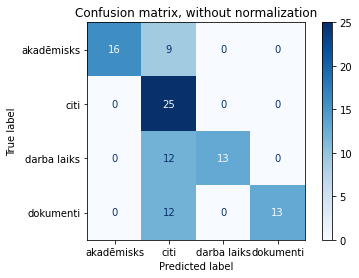

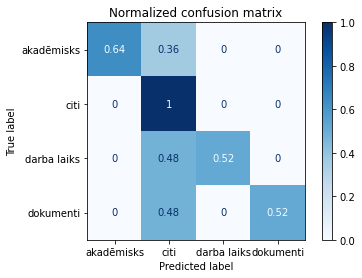

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import plot_confusion_matrix, f1_score, classification_report
y_pred = naive_bayes.predict(questions1)                                                 # Prasam modelim paredzēt testa datiem kategorijas
y_test = Y.to_numpy()
class_names = ['akadēmisks', 'citi', 'darba laiks', 'dokumenti']
naive_f1_avg = round(f1_score(y_test, y_pred, average='macro'),4)                        # Fiksējam Naive Bayes f1 vidējo rezultātu
print('Naive Bayes F1 score:', naive_f1_avg)
print(classification_report(y_test, y_pred, target_names=class_names))

np.set_printoptions(precision=2)
titles_options = [("Confusion matrix, without normalization", None),                     # Plot non-normalized confusion matrix
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(naive_bayes, questions1, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)
plt.show()

<h3> Keras bāzlīnijas izvērtēšana - klasifikācijas atskaite un pārpratumu matrica</h3>

In [0]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, classification_report, confusion_matrix
y_pred = model.predict(questions2)                                                       # Prasam modelim paredzēt testa datiem kategorijas
keras_y_pred = transformResults(y_pred)                                         # Pārveidojam rezultātus, paņemot ticamāko klasi no varbūtībām
y_test = Y.to_numpy()
class_names = ['akadēmisks', 'citi', 'darba laiks', 'dokumenti']
naive_f1_avg = round(f1_score(y_test, keras_y_pred, average='macro'),4)               # Fiksējam Naive Bayes f1 vidējo rezultātu
print('Naive Bayes F1 score:', naive_f1_avg)
print(classification_report(y_test, keras_y_pred, target_names=class_names))
print(confusion_matrix(y_test, keras_y_pred, normalize=None))
print(confusion_matrix(y_test, keras_y_pred, normalize='true'))

Naive Bayes F1 score: 0.7231
              precision    recall  f1-score   support

  akadēmisks       1.00      0.84      0.91        25
        citi       0.47      0.96      0.63        25
 darba laiks       1.00      0.36      0.53        25
   dokumenti       0.95      0.72      0.82        25

    accuracy                           0.72       100
   macro avg       0.85      0.72      0.72       100
weighted avg       0.85      0.72      0.72       100

[[21  4  0  0]
 [ 0 24  0  1]
 [ 0 16  9  0]
 [ 0  7  0 18]]
[[0.84 0.16 0.   0.  ]
 [0.   0.96 0.   0.04]
 [0.   0.64 0.36 0.  ]
 [0.   0.28 0.   0.72]]
